In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [38]:
def amdahl(nworkers, p):
    return 1 / (1 - p + p/nworkers)

def efficiency(nworkers, p):
    return 1 /(nworkers * (1 - p + p/nworkers))

def expfit(nworkers,offset, decay1, decay2):
    return offset - decay1 * np.exp(-nworkers* decay2)
def linfit(nworkers, offset, slope):
    return offset + slope * nworkers

In [3]:
data_no_bunch = np.loadtxt("Results/scaling_no_batch.out", delimiter=",")
jobID = ['63', '66', '70', '77', '79']
Data = np.zeros((63, 4, len(jobID)))
for i in range(len(jobID)):
    Data[:,:,i] = np.loadtxt("Results/slurm-1374"+jobID[i]+".out", delimiter=",")
Data[:,0,:] = Data[:,0,:] -1
data_no_bunch[:,0] = data_no_bunch[:,0] -1

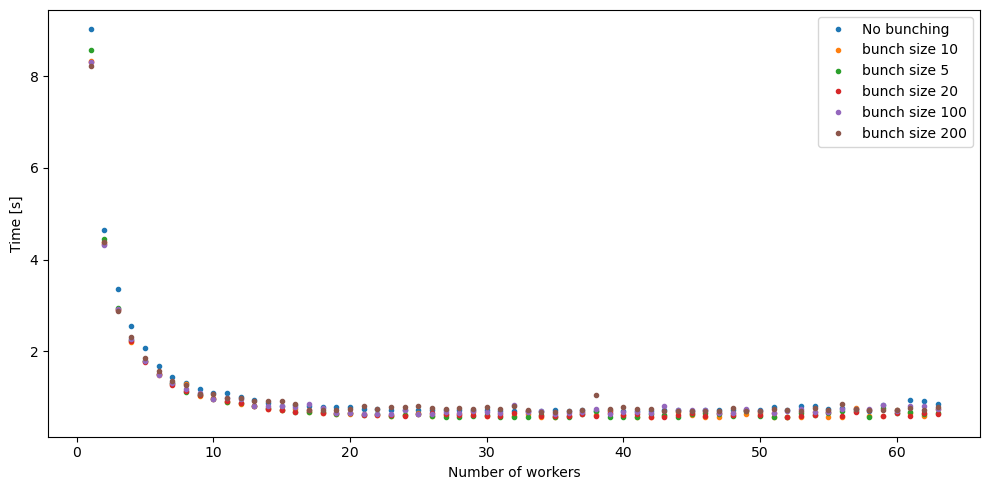

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_no_bunch[:,0], data_no_bunch[:,1], '.', label='No bunching')
for i in range(len(jobID)):
    ax.plot(Data[:,0,i], Data[:,1,i], '.', label=f'bunch size {int(Data[0,3,i])}')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Time [s]')
ax.legend()
fig.tight_layout()

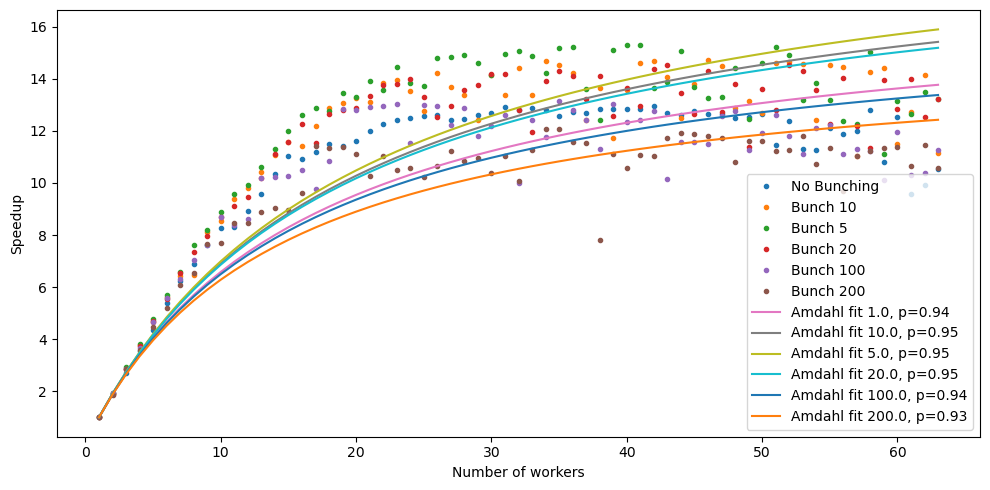

In [5]:
from scipy import optimize
fitval = np.zeros(len(jobID)+1)
fit = optimize.curve_fit(amdahl, data_no_bunch[:,0], data_no_bunch[0,1]/data_no_bunch[:,1])
fitval[0] = fit[0][0]
bunch_size = np.ones(len(jobID)+1)
for i in range(len(jobID)):
    fit = scipy.optimize.curve_fit(amdahl, Data[:,0,i], Data[0,1,i]/Data[:,1,i])
    fitval[i+1] = fit[0][0]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(data_no_bunch[:,0], data_no_bunch[0,1]/data_no_bunch[:,1], '.', label='No Bunching')
for i in range(len(jobID)):
    ax.plot(Data[:,0,i], Data[0,1,i]/Data[:,1,i], '.', label=f'Bunch {int(Data[0,3,i])}')
    bunch_size[i+1] = int(Data[0,3,i])

for i in range(len(jobID)+1):
    ax.plot(data_no_bunch[:,0], amdahl(data_no_bunch[:,0], fitval[i]), label=f'Amdahl fit {bunch_size[i]}, p={fitval[i]:.2f}')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Speedup')
ax.legend()
fig.tight_layout()

In [32]:
data_5a = np.loadtxt("Results/n_cuts5_1.out", delimiter=",",usecols=[0,1,2,3,4,5])
data_5b = np.loadtxt("Results/n_cuts5_2.out", delimiter=",",usecols=[0,1,2,3,4,5])
data_5c = np.loadtxt("Results/n_cuts5_3.out", delimiter=",",usecols=[0,1,2,3,4,5])

data_5 = np.concatenate((data_5a, data_5b), axis=0)
data_5 = np.concatenate((data_5, data_5c), axis=0)
print(data_5[0,:])

[2.00000000e+00 8.35665962e+02 8.35741864e+02 1.00000000e+00
 4.48089281e+01 3.86682649e-02]


C:\Users\Jens\AppData\Local\Temp\ipykernel_19844\1469538487.py:8: RuntimeWarning: overflow encountered in exp
  return offset - decay1 * np.exp(-nworkers* decay2)


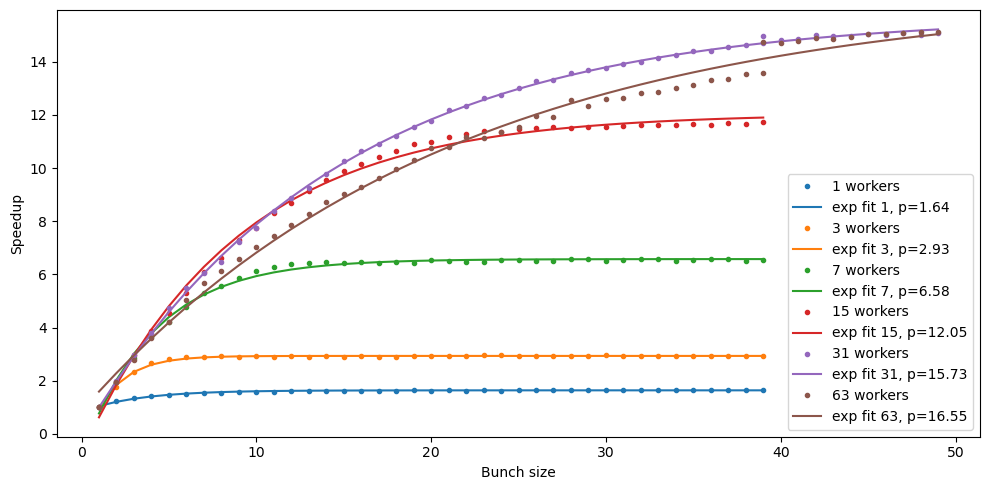

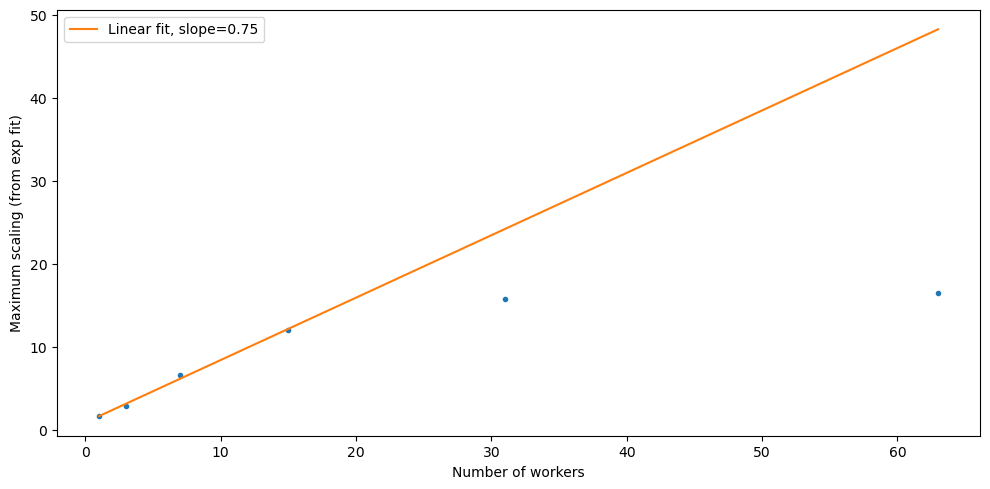

In [41]:
workers = np.array([2, 4, 8, 16, 32, 64])
max_scaling = np.zeros(len(workers))
fig, ax = plt.subplots(figsize=(10,5))
for i in range(len(workers)):
    mask = np.arange(len(data_5))[data_5[:,0] == workers[i]]
    CN = 'C'+str(i)
    ax.plot(data_5[mask,3], data_5[mask[0],2]/data_5[mask,2], '.', color=CN, label=f'{workers[i]-1} workers')
    fit = scipy.optimize.curve_fit(expfit, data_5[mask,3], data_5[mask[0],2]/data_5[mask,2])
    # ax.plot(data_5[mask,3], amdahl(data_5[mask,3], fit[0][0]),color=CN, label=f'Amdahl fit {workers[i]-1}, p={fit[0][0]:.2f}')
    ax.plot(data_5[mask,3], expfit(data_5[mask,3],fit[0][0],fit[0][1],fit[0][2]),color=CN, label=f'exp fit {workers[i]-1}, p={fit[0][0]:.2f}')
    max_scaling[i] = fit[0][0]
ax.set_ylabel('Speedup')
ax.set_xlabel('Bunch size')
ax.legend()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,5))
fit = scipy.optimize.curve_fit(linfit, workers[:4]-1, max_scaling[:4])
ax.plot(workers-1, max_scaling, '.')
ax.plot(workers-1, linfit(workers-1, fit[0][0], fit[0][1]), label=f'Linear fit, slope={fit[0][1]:.2f}')
ax.set_xlabel('Number of workers')
ax.set_ylabel('Maximum scaling (from exp fit)')
ax.legend()
fig.tight_layout()

(256,)


Text(0.5, 0, 'Bunch size')

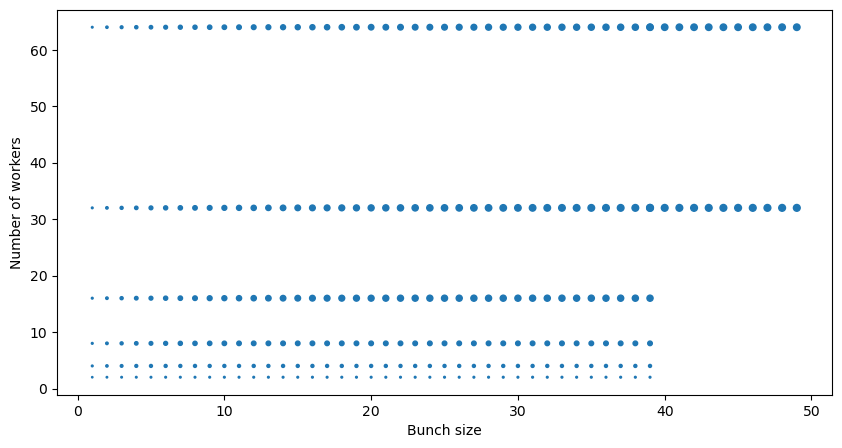

In [42]:
data_0 = np.loadtxt("Results/t0.txt")
data_5_scaling = data_0/data_5[:,2]
print(data_5_scaling.shape)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(data_5[:,3], data_5[:,0], s=data_5_scaling*100)
ax.set_ylabel('Number of workers')
ax.set_xlabel('Bunch size')